In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the dataset
file_path = 'Merged_GNSS_and_SNR_Data.csv'
gnss_data = pd.read_csv(file_path)

# Define numerical and categorical columns
numerical_cols = ['Phase Residual (m)', 'Pseudorange Residual (m)', 
                  'STD of Pseudorange L1 (m)', 'STD of Pseudorange L2 (m)', 
                  'Elevation (¡Æ)', 'Azimuth (¡Æ)', 'SNR(dBHz)']

categorical_cols = ['PRN', 'Signal Type 1', 'Signal Type 2']

# Drop irrelevant or target-related columns from input features
X = gnss_data.drop(columns=['TIME', 'L1 MP(m)', 'C1 Code', 'C2 Code', 'DSI'])


# Target variable (multipath effect on L1 MP)
y = gnss_data['L1 MP(m)']

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both train and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert sparse matrices to dense
X_train_preprocessed = X_train_preprocessed.toarray()  # Convert sparse matrix to dense
X_test_preprocessed = X_test_preprocessed.toarray()    # Convert sparse matrix to dense

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)

rf_model.fit(X_train_preprocessed, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min


RandomForestRegressor(random_state=42, verbose=1)

In [5]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, warm_start=True)

# Initialize tqdm for progress monitoring
with tqdm(total=rf_model.n_estimators, desc="Training Random Forest") as pbar:
    for i in range(1, rf_model.n_estimators + 1):
        # Update the number of trees in the forest
        rf_model.n_estimators = i
        
        # Fit the model with the current number of trees
        rf_model.fit(X_train_preprocessed, y_train)
        
        # Update the progress bar
        pbar.update(1)


Training Random Forest: 100%|█████████████████| 100/100 [02:45<00:00,  1.65s/it]


In [6]:
# Predict using the Random Forest model
y_pred_rf = rf_model.predict(X_test_preprocessed)

# Calculate MAE for Random Forest
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {rf_mae}")

Random Forest MAE: 0.09623093139961929


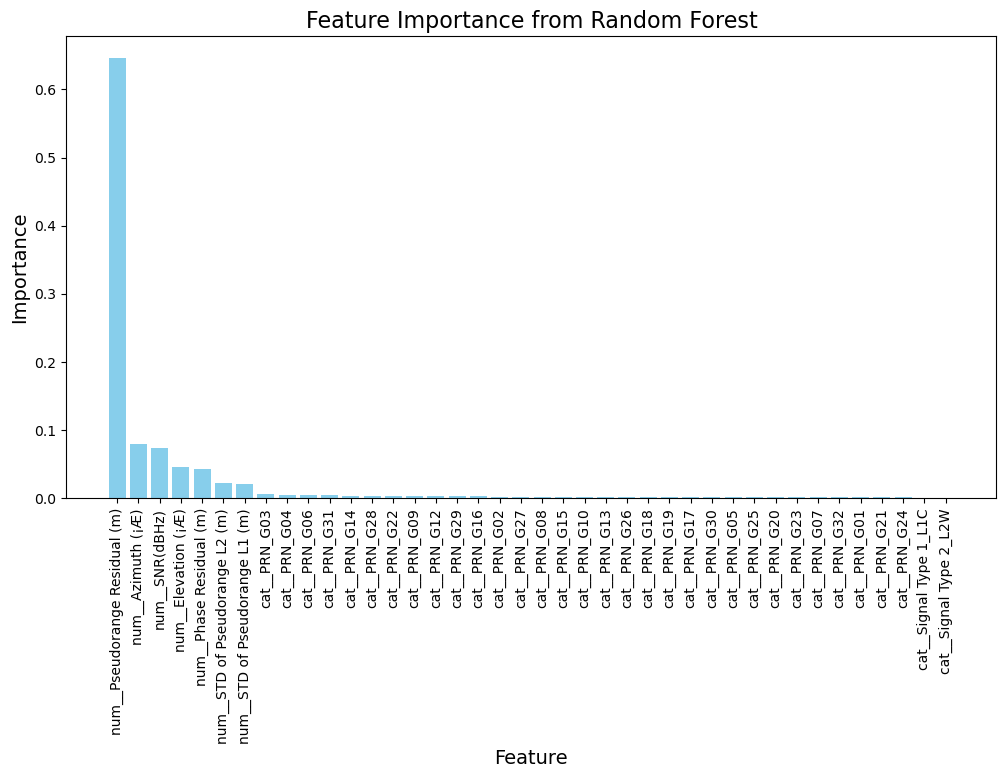

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Get feature names from the preprocessing step
feature_names = preprocessor.get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importance from Random Forest', fontsize=16)
plt.bar(range(len(importances)), importances[indices], align='center', color='skyblue')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.show()


In [8]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

# Initialize a RandomForestRegressor model
rfe_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize tqdm for progress monitoring
n_features = X_train_preprocessed.shape[1]  # Total number of features
with tqdm(total=n_features, desc="RFE Progress") as pbar:
    # Perform recursive feature elimination manually
    selector = RFE(estimator=rfe_model, n_features_to_select=5, step=1, verbose=0)
    
    # Hook into the fitting process to update tqdm at each step
    for i in range(n_features - 5):
        selector = selector.fit(X_train_preprocessed, y_train)
        pbar.update(1)

# Get ranking of features
ranking = selector.ranking_

# Display the features and their rankings
for i in range(len(ranking)):
    print(f"Feature: {feature_names[i]}, Rank: {ranking[i]}")


RFE Progress:  88%|███████████████████▎  | 35/40 [68:28:33<9:46:56, 7043.25s/it]

Feature: num__Phase Residual (m), Rank: 1
Feature: num__Pseudorange Residual (m), Rank: 1
Feature: num__STD of Pseudorange L1 (m), Rank: 3
Feature: num__STD of Pseudorange L2 (m), Rank: 2
Feature: num__Elevation (¡Æ), Rank: 1
Feature: num__Azimuth (¡Æ), Rank: 1
Feature: num__SNR(dBHz), Rank: 1
Feature: cat__PRN_G01, Rank: 32
Feature: cat__PRN_G02, Rank: 17
Feature: cat__PRN_G03, Rank: 4
Feature: cat__PRN_G04, Rank: 5
Feature: cat__PRN_G05, Rank: 24
Feature: cat__PRN_G06, Rank: 6
Feature: cat__PRN_G07, Rank: 30
Feature: cat__PRN_G08, Rank: 16
Feature: cat__PRN_G09, Rank: 11
Feature: cat__PRN_G10, Rank: 18
Feature: cat__PRN_G12, Rank: 12
Feature: cat__PRN_G13, Rank: 20
Feature: cat__PRN_G14, Rank: 9
Feature: cat__PRN_G15, Rank: 19
Feature: cat__PRN_G16, Rank: 15
Feature: cat__PRN_G17, Rank: 25
Feature: cat__PRN_G18, Rank: 23
Feature: cat__PRN_G19, Rank: 21
Feature: cat__PRN_G20, Rank: 28
Feature: cat__PRN_G21, Rank: 33
Feature: cat__PRN_G22, Rank: 10
Feature: cat__PRN_G23, Rank: 29
Featu